In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [8]:
# 기본 한글 폰트 설정 (시각화 한글 깨짐 방지)
plt.rcParams['font.family'] = 'Malgun Gothic'
# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 활성시간때의 따릉이 수요가 제일 불균형한 지역 선별
1. K-means를 이용해서 각 자치구들을 클러스터링
2. 클러스터링 결과론 나온 각 클러스터들의 특징을 파악
3. 클러스터의 특징을 파악을 통해서 불균형 클러스터 선별

In [11]:
df = pd.read_csv("./data/columns/merged_활성시간.csv")

## 각 컬럼 소개
1. 자치구 - 자치구
2. 시간_구분 - 이용량을 기준으로 시간을 나눔
    - 활성시간 : 이용량이 제일 많은 시간때(8, 16, 17, 18, 19, 20)
    - 비활성시간 : 이용량이 제일 적은 시간떄( 1, 2, 3, 4, 5, 23)
    - 중간시간 : 이용량이 중간인 시간때(0, 6, 7, 9, 10, 11, 12, 13, 14, 15, 21, 22)
3. 대여_건수 : 따릉이의 대여건수 (개)
4. 반납_건수 : 따릉이의 반납건수 (개)
5. |대여-반납| : 대여건수와 반납 건수의 차이(각 자치구마다의 대여건수와 반납건수의 차이) (개)
6. 빈대여소의비율 : 각 시간때의 자치구마다의 빈대여소의 수 / 자치구의 전체 대여소의 수를 구한 뒤 시간_구분의 시간때의 평균 (%)
7. std : 빈 대여소의 시간으로 묶은 값의 표준편차
8. 빈대여소시간 : 각 자치구마다 빈 대여소가 몇시간 있는지 (시간)
9. 유출량 : 자치구에서 다른 자치구로 유출된 따릉이의 갯수 (개)
10. 유입량 : 자치구에서 다른 자치구로 부터 유입된 따릉이의 갯수 (개)
11. 회전율 : (대여건수 + 반납건수) / 각 자치구의 대여소의 수(얼마나 따릉이가 활발하게 사용되는지)
12. 최대 이용량 : 24시간중 가장 따릉이가 많이 이용된 갯수 (개)
13. 최소 이용량 : 24시간중 가장 따릉이가 적게 이용된 갯수 (개)
14. 최대최소_편차 : 최대이용량 - 최소이용량 (개)
15. 대여소의 개수 : 각 자치구마다의 대여소의 갯수 (개)
16. 면적 : 자치구의 면적 (km²)
17. 밀도 : 자치구의 대여소의 갯수 / 자치구의 면적 (개/km²)
18. 이동량 : |유입량 - 유출량|, 다른 자치구로부터 따릉이가 얼마나 이동했는지 (개)

In [14]:
df.head()

,자치구,시간_구분,대여_건수,반납_건수,|대여-반납|,빈대여소의비율,std,빈대여소시간,유출량,유입량,회전율,최대이용량,최소이용량,최대최소_편차,대여소_개수,면적,밀도(개/km²),이동량
0,강남구,활성,152997,139834,13163,0.216570,0.037731,5811,2771,2162,1645.117978,35009,1935,33074,189,39.51,4.783599,609
1,강동구,활성,182775,189338,6563,0.081178,0.006034,1431,1815,1980,3180.452991,40674,2346,38328,137,24.58,5.573637,165
2,강북구,활성,51588,51014,574,0.115171,0.016822,1078,915,914,1710.033333,10667,1473,9194,69,23.61,2.922490,1
3,강서구,활성,523925,526801,2876,0.063394,0.013237,1879,1782,1864,5501.183246,117428,4750,112678,217,41.43,5.237750,82
4,관악구,활성,82468,84885,2417,0.128117,0.007158,1459,1147,1172,2202.013158,18205,2032,16173,95,29.57,3.212716,25


- 파생변수를 만들기 위해서 사용했던 컬럼들을 삭제

In [17]:
df = df.drop(columns = ["대여_건수", "반납_건수","최대이용량", "최소이용량", "대여소_개수", "면적", "유입량", "유출량"])

In [19]:
df.head()

,자치구,시간_구분,|대여-반납|,빈대여소의비율,std,빈대여소시간,회전율,최대최소_편차,밀도(개/km²),이동량
0,강남구,활성,13163,0.216570,0.037731,5811,1645.117978,33074,4.783599,609
1,강동구,활성,6563,0.081178,0.006034,1431,3180.452991,38328,5.573637,165
2,강북구,활성,574,0.115171,0.016822,1078,1710.033333,9194,2.922490,1
3,강서구,활성,2876,0.063394,0.013237,1879,5501.183246,112678,5.237750,82
4,관악구,활성,2417,0.128117,0.007158,1459,2202.013158,16173,3.212716,25


## 입력변수
- 입력변수들은 따릉이 도메인 지식을 활용해서 변수 생성

- 각 자치구별 따릉이 수요 불균형을 나타내는 변수
  1. |대여-반납| : 각 자치구 별로 대여의 갯수와 반납의 갯수의 차이를 통해서 수요의 순흐름 규모 파악
     - 값이 크면 자전거 재고가 한쪽으로 쏠리기 쉬움
    
  2. 빈대여소의비율, 빈대여소시간 : 관측시간대의 빈대여소의 비율, 빈대여소가 얼마나 길게 이어졌는지의 시간을 파악
     - 불균형이 체감되는 빈도, 빈대여소의 비율이 높을 수록 시간이 클 수록 따릉이 불균형의 빈도를 확인할 수 있음
    
  3. 이동량 : 자치구간의 순외부흐름 파악
     - 이동량이 크다는 것은 자치구내의 유입이 많거나 유출이 많다는 것을 알 수 있음
    
  4. 최대최소_편차 : 시간대별 수요의 진폭을 파악
     - 피크타임과 비피크타임때의 격차가 클 수록 시간적인 면으로 불균형하다는 것을 확인 할 수 있음
    
- 각 자치구별 따릉이 사용 특징을 파악하기 위한 변수(직접적으로 불균형이 있다고 판단할 수 없는 변수)
  1. 회전율 : 단위 대여소 대비 처리된 이용량을 파악
     - 회전율이 높으면 따릉이 이용이 활발함
    
  2. 밀도 : 공간적인면에서 각 자치구별 대여소의 집중도를 파악

In [22]:
select = ["|대여-반납|", "빈대여소의비율", "빈대여소시간", "회전율", "최대최소_편차", "밀도(개/km²)", "이동량"]

- 각 독립변수간의 상관계수 파악

In [25]:
corr_matrix = df[select].corr()

In [27]:
corr_matrix

,|대여-반납|,빈대여소의비율,빈대여소시간,회전율,최대최소_편차,밀도(개/km²),이동량
|대여-반납|,1.000000,0.251427,0.376353,0.209844,0.175695,0.536443,0.815685
빈대여소의비율,0.251427,1.000000,0.799921,-0.441269,-0.284555,0.163811,0.453250
빈대여소시간,0.376353,0.799921,1.000000,-0.197092,0.157831,0.186341,0.645341
회전율,0.209844,-0.441269,-0.197092,1.000000,0.835319,0.397662,-0.083014
최대최소_편차,0.175695,-0.284555,0.157831,0.835319,1.000000,0.321849,0.111393
밀도(개/km²),0.536443,0.163811,0.186341,0.397662,0.321849,1.000000,0.397198
이동량,0.815685,0.453250,0.645341,-0.083014,0.111393,0.397198,1.000000


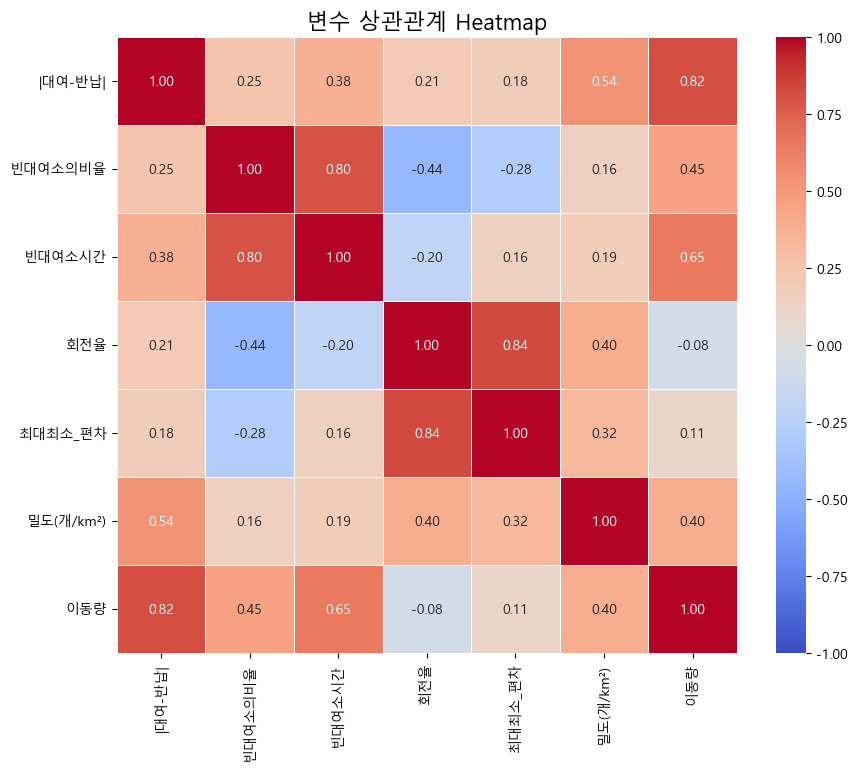

In [29]:
# Heatmap으로 시각화
plt.figure(figsize=(10, 8))

sns.heatmap(
    corr_matrix, 
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1,
    linewidths=0.5
)
plt.title("변수 상관관계 Heatmap", fontsize=16)

plt.show()

### 상관계수가 높게 나온 컬럼

- 빈대여소의비율과 빈대여소시간의 상관계수가 0.79
  - 빈대여소가 많으면 많을 수록 빈대여소의 시간이 늘어남 서로 양의 상관관계가 있음
- |대여-반납|과 이동량의 상관계수가 0.81
  - 서로 양의 상관관계를 가지고 있지만 이동량은 따릉이의 유출 - 유입이기 때문에 서로 다른 컬럼

## 군집화 진행
1. 모든 변수들이 단위가 다르기 때문에 정규화를 진행해서 단위를 통일해줌
2. 엘보우기법으로 몇개의 군집이 최적인지 찾음
3. 엘보우 기법으로 찾은 k값을 기반으로 K-means 모델 생성
4. K-means로 군집화 진행

In [33]:
x = df[select]

In [35]:
#정규화
x_scaled = StandardScaler().fit_transform(x)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows wi

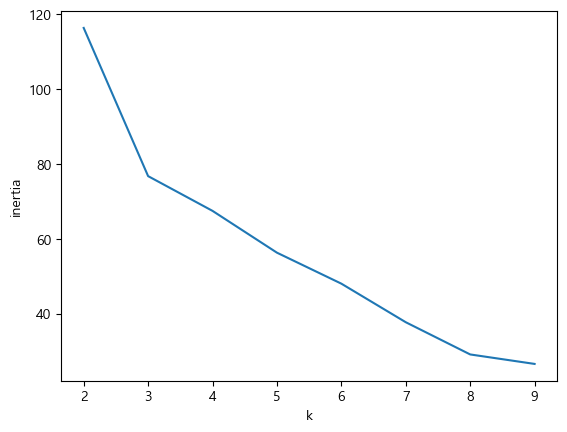

In [37]:
# k를 2부터 10까지 해서 최적의 k 값 찾기
inertia = []

for k in range(2,10) :
    km = KMeans(n_clusters = k, random_state = 26)
    km.fit(x_scaled)
    inertia.append(km.inertia_)

plt.plot(range(2, 10), inertia)
plt.xlabel("k")
plt.ylabel("inertia")
plt.show()

In [39]:
# k를 3으로 넣고 k-means 모델생성
model = KMeans(n_clusters = 3, random_state = 26,  n_init=10)

In [41]:
# 정규환된 입력변수를 이용해서 모델 학습
model.fit(x_scaled)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=3, n_init=10, random_state=26)

In [43]:
# 0,1,2로 라벨링이되어있음
np.unique(model.labels_)

array([0, 1, 2])

In [45]:
group = df.copy()

In [47]:
# 클러스터링이 진행되고나서 진행된 값을 cluster라는 컬럼에 넣음
group["cluster"] = model.predict(x_scaled)

In [49]:
group = group.sort_values("cluster").reset_index(drop=True)

In [51]:
group

,자치구,시간_구분,|대여-반납|,빈대여소의비율,std,빈대여소시간,회전율,최대최소_편차,밀도(개/km²),이동량,cluster
0,마포구,활성,144,0.153259,0.027617,2869,3520.084034,46639,5.946399,28,0
1,강동구,활성,6563,0.081178,0.006034,1431,3180.452991,38328,5.573637,165,0
2,강서구,활성,2876,0.063394,0.013237,1879,5501.183246,112678,5.237750,82,0
3,광진구,활성,6608,0.139481,0.012472,1806,4814.674699,41288,6.330598,35,0
4,구로구,활성,3537,0.054094,0.012661,962,3216.182609,41364,6.163022,63,0
5,영등포구,활성,12786,0.119065,0.044707,2879,4794.955975,83550,7.733008,346,0
6,노원구,활성,3372,0.114997,0.024294,2673,3308.238411,48389,4.796840,6,0
7,양천구,활성,10655,0.045392,0.012742,757,4616.098214,54800,6.896552,202,0
8,동대문구,활성,7714,0.069809,0.008737,893,3273.560976,26264,7.323944,176,0
9,송파구,활성,4741,0.132033,0.010730,4449,3785.036866,88945,7.201889,169,0


In [53]:
group["cluster"].value_counts()

cluster
0    11
1    11
2     3
Name: count, dtype: int64

### 클러스터링 결과 
- 3개로 자치구를 나눴을 때 0번 : 11개, 1번 11개, 2번 3개 이렇게 클러스터링 결과가 나옴

## 각 클러스터들을 특징 파악
- 각 클러스터들의 평균을 구하고 비교 분석

In [57]:
# cluster_means는 각각 클러스터의 평균
# all_means는 전체 평균
cluster_means = group.groupby("cluster")[select].mean(numeric_only=True)
all_means = group[select].mean().to_frame().T

In [59]:
all_means

,|대여-반납|,빈대여소의비율,빈대여소시간,회전율,최대최소_편차,밀도(개/km²),이동량
0,5415.2,0.135945,2292.28,2913.571603,36150.56,5.560727,137.56


In [61]:
cluster_means

,|대여-반납|,빈대여소의비율,빈대여소시간,회전율,최대최소_편차,밀도(개/km²),이동량
cluster,,,,,,,
0,6107.090909,0.100709,2052.636364,3975.816242,56411.454545,6.333862,118.454545
1,2851.636364,0.132568,1798.000000,2104.809209,18570.727273,4.443994,71.636364
2,12278.000000,0.277528,4983.333333,1984.136711,26320.000000,6.820582,449.333333


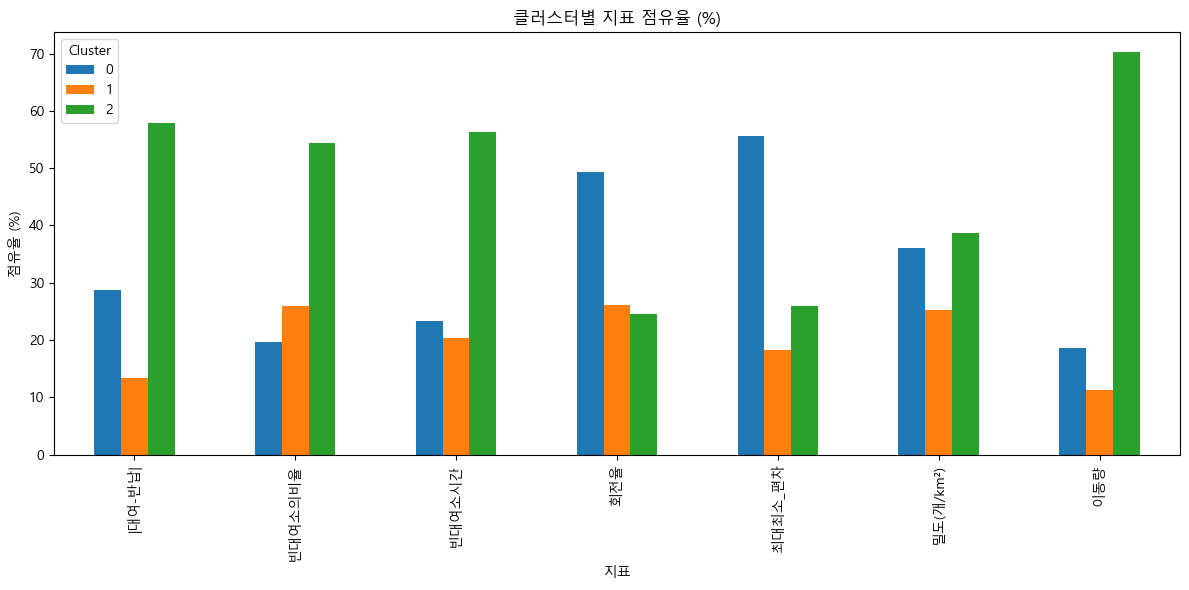

In [63]:
# 3개의 클러스터를 100분율로 계산
share = cluster_means.div(cluster_means.sum(axis=0), axis=1) * 100

share.T.plot(kind="bar", figsize=(12,6)) #bar형태로 그림

plt.title("클러스터별 지표 점유율 (%)")
plt.xlabel("지표")
plt.ylabel("점유율 (%)")
plt.legend(title="Cluster")
plt.tight_layout()

plt.show()

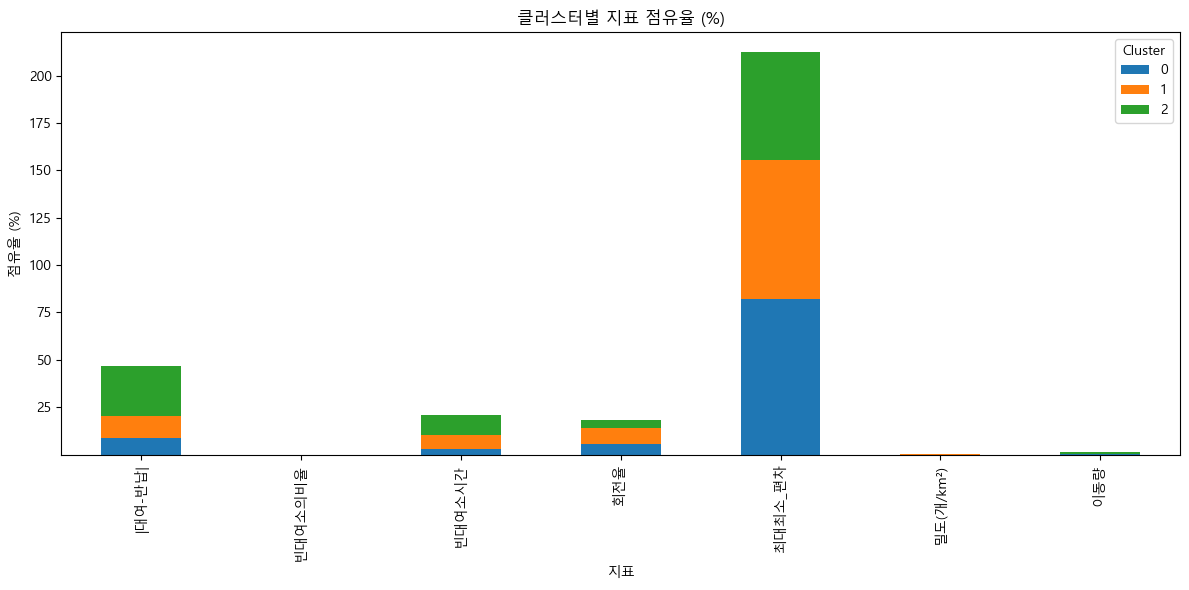

In [65]:
# 클러스터별 상대적으로 시각화 (스택형 막대그래프)
share = cluster_means.div(cluster_means.sum(axis=1), axis=0) * 100

share.T.plot(kind="bar", stacked=True, figsize=(12,6))

plt.title("클러스터별 지표 점유율 (%)")
plt.xlabel("지표")
plt.ylabel("점유율 (%)")
plt.legend(title="Cluster")
plt.tight_layout()

plt.show()

## 컬럼별 분석

- 전체 평균과 각 클러스터의 평균 값을 비교분석

- 따릉이 수요 불균형을 나타내는 컬럼들을 살펴봄
  1. |대여-반납|
  2. 빈대여소의 비율, 빈대여소시간
  3. 이동량
  4. 최대최소_편차

## |대여-반납|

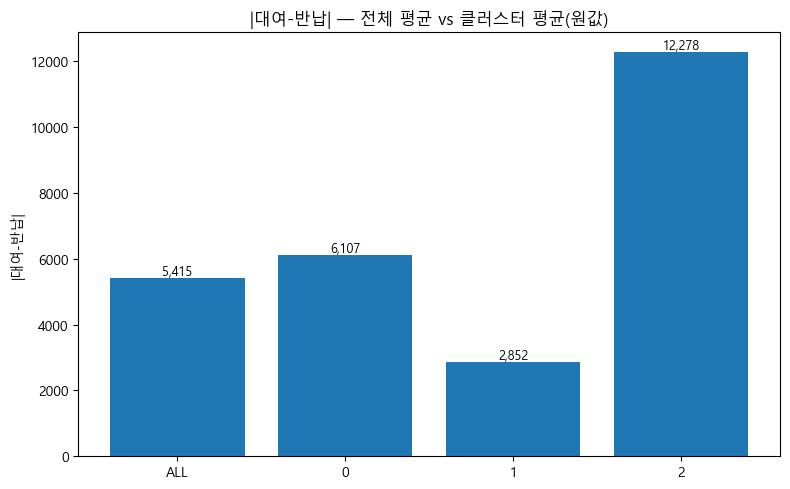

In [69]:
metric = "|대여-반납|"

# 전체 평균(ALL) 스칼라 추출
overall = all_means.squeeze()[metric]   

# 클러스터별 평균 Series
cm = cluster_means[metric]              

# 간단한 요약(개수)
above = (cm > overall).sum()
below = (cm < overall).sum()
equal = (cm == overall).sum()

# 막대그래프 
labels = ["ALL"] + [str(c) for c in cm.index]
values = [overall] + cm.tolist()

x = np.arange(len(labels))
plt.figure(figsize=(8,5))
plt.bar(x, values)
plt.xticks(x, labels)
plt.ylabel(metric)
plt.title(f"{metric} — 전체 평균 vs 클러스터 평균(원값)")

# 값 라벨 표시
for xi, v in zip(x, values):
    plt.text(xi, v, f"{v:,.0f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

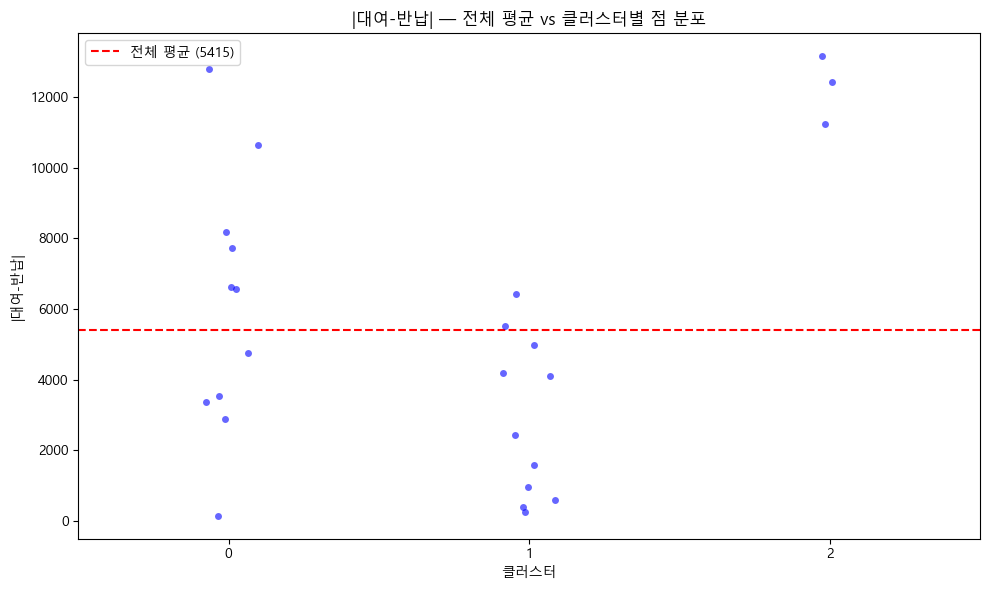

In [71]:
plt.figure(figsize=(10, 6))

sns.stripplot(data=group, x="cluster", y="|대여-반납|", jitter=True, color='blue', alpha=0.6)
plt.axhline(y=overall, color='r', linestyle='--', label=f"전체 평균 ({overall:.0f})")
plt.title(f"{metric} — 전체 평균 vs 클러스터별 점 분포")
plt.xlabel("클러스터")
plt.ylabel(f"{metric}")
plt.legend()

plt.tight_layout()
plt.show()

## 빈대여소의비율

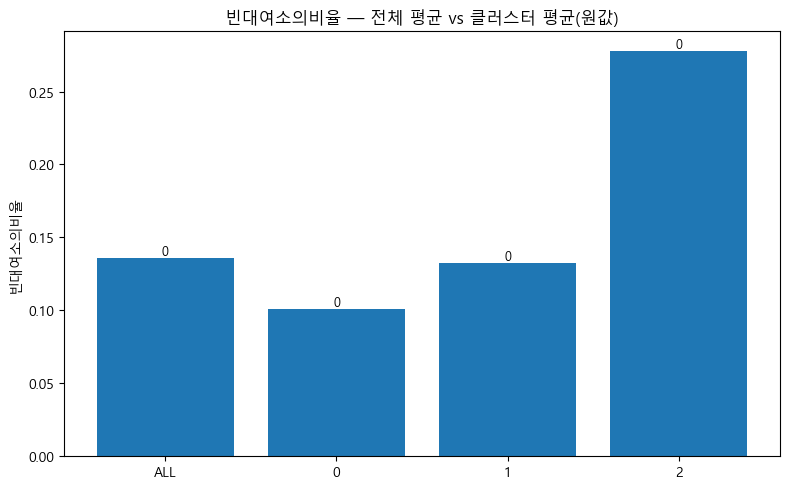

In [74]:
metric = "빈대여소의비율"

# 전체 평균(ALL) 스칼라 추출
overall = all_means.squeeze()[metric]   

# 클러스터별 평균 Series
cm = cluster_means[metric]             

# 간단한 요약(개수)
above = (cm > overall).sum()
below = (cm < overall).sum()
equal = (cm == overall).sum()

# 막대그래프 
labels = ["ALL"] + [str(c) for c in cm.index]
values = [overall] + cm.tolist()

x = np.arange(len(labels))
plt.figure(figsize=(8,5))
plt.bar(x, values)
plt.xticks(x, labels)
plt.ylabel(metric)
plt.title(f"{metric} — 전체 평균 vs 클러스터 평균(원값)")

# 값 라벨 표시
for xi, v in zip(x, values):
    plt.text(xi, v, f"{v:,.0f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_20460\4170077961.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=group, x="cluster", y="빈대여소의비율", palette="Set1")


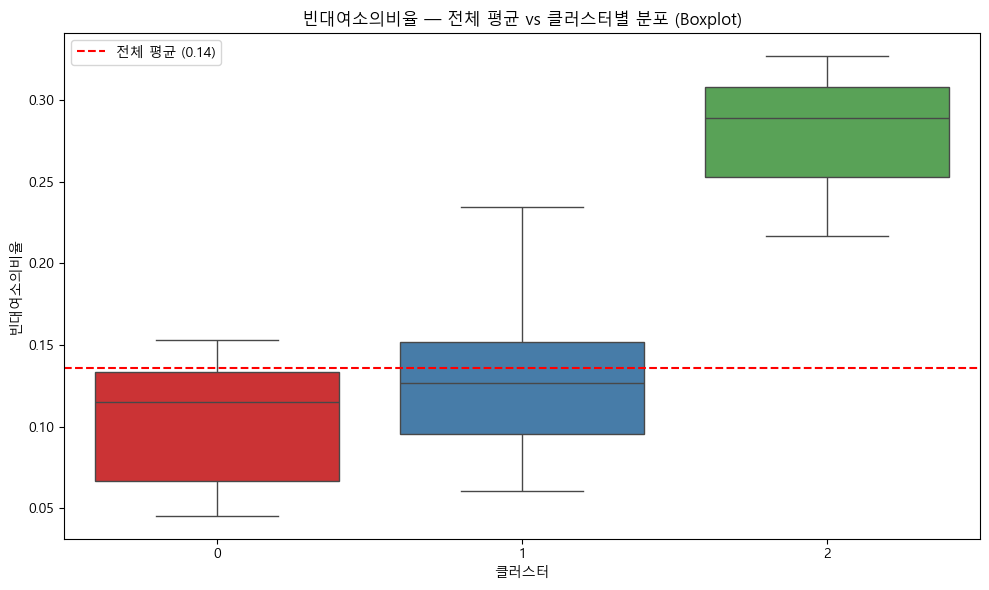

In [76]:
plt.figure(figsize=(10, 6))

sns.boxplot(data=group, x="cluster", y="빈대여소의비율", palette="Set1")
plt.axhline(y=overall, color='r', linestyle='--', label=f"전체 평균 ({overall:.2f})")
plt.title(f"{metric} — 전체 평균 vs 클러스터별 분포 (Boxplot)")
plt.xlabel("클러스터")
plt.ylabel(f"{metric}")
plt.legend()

plt.tight_layout()
plt.show()

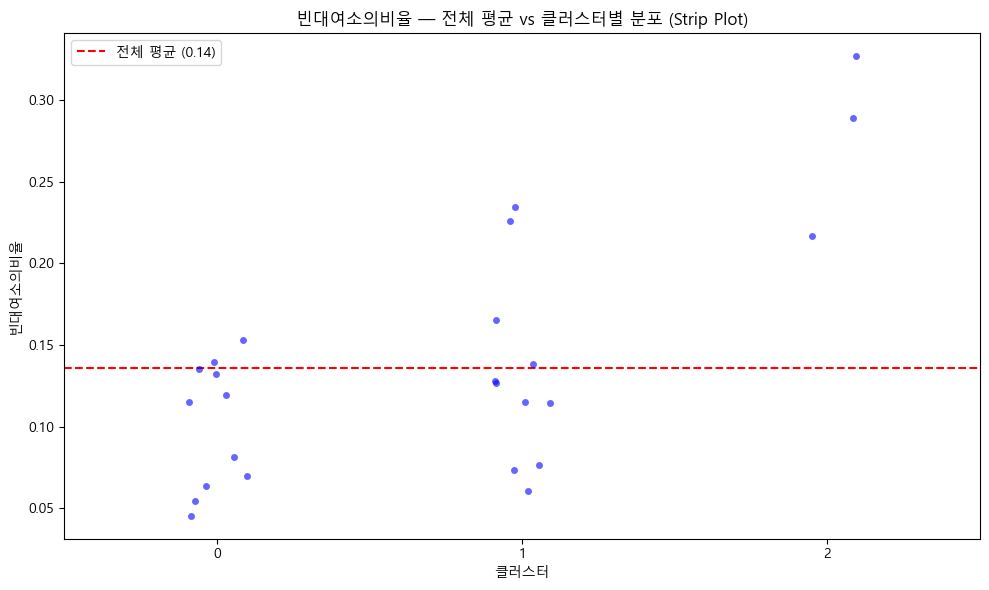

In [78]:
plt.figure(figsize=(10, 6))

sns.stripplot(data=group, x="cluster", y="빈대여소의비율", jitter=True, color='blue', alpha=0.6)
plt.axhline(y=overall, color='r', linestyle='--', label=f"전체 평균 ({overall:.2f})")
plt.title(f"{metric} — 전체 평균 vs 클러스터별 분포 (Strip Plot)")
plt.xlabel("클러스터")
plt.ylabel(f"{metric}")
plt.legend()

plt.tight_layout()
plt.show()

## 빈대여소시간

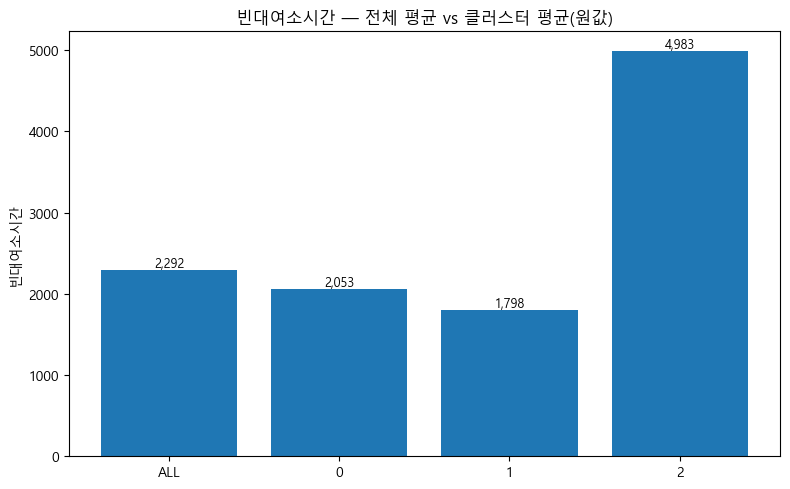

In [81]:
metric = "빈대여소시간"

# 전체 평균(ALL) 스칼라 추출
overall = all_means.squeeze()[metric]   

# 클러스터별 평균 Series
cm = cluster_means[metric]              

# 간단한 요약(개수)
above = (cm > overall).sum()
below = (cm < overall).sum()
equal = (cm == overall).sum()

# 막대그래프 
labels = ["ALL"] + [str(c) for c in cm.index]
values = [overall] + cm.tolist()

x = np.arange(len(labels))
plt.figure(figsize=(8,5))
plt.bar(x, values)
plt.xticks(x, labels)
plt.ylabel(metric)
plt.title(f"{metric} — 전체 평균 vs 클러스터 평균(원값)")

# 값 라벨 표시
for xi, v in zip(x, values):
    plt.text(xi, v, f"{v:,.0f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

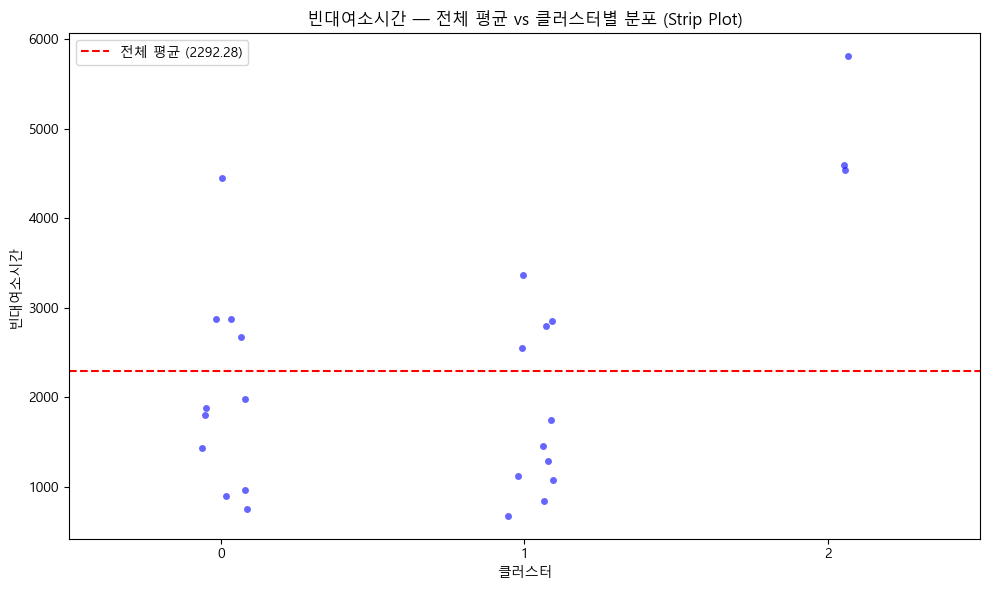

In [83]:
plt.figure(figsize=(10, 6))

sns.stripplot(data=group, x="cluster", y="빈대여소시간", jitter=True, color='blue', alpha=0.6)
plt.axhline(y=overall, color='r', linestyle='--', label=f"전체 평균 ({overall:.2f})")
plt.title(f"{metric} — 전체 평균 vs 클러스터별 분포 (Strip Plot)")
plt.xlabel("클러스터")
plt.ylabel(f"{metric}")
plt.legend()

plt.tight_layout()
plt.show()

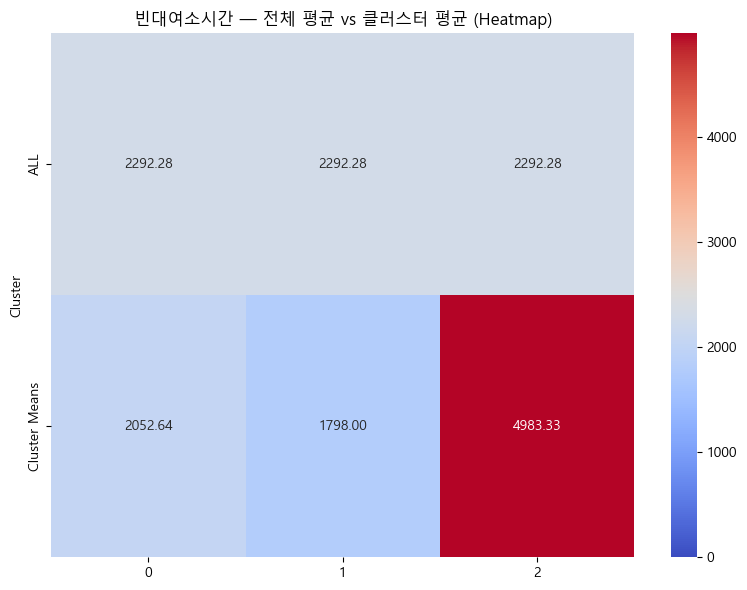

In [85]:
data = pd.DataFrame({
    "ALL": [overall] * len(cm),
    "Cluster Means": cm.tolist()
}, index=[str(c) for c in cm.index])

plt.figure(figsize=(8, 6))
sns.heatmap(data.T, annot=True, cmap="coolwarm", vmin=0, vmax=max(cm.max(), overall), fmt=".2f")
plt.title(f"{metric} — 전체 평균 vs 클러스터 평균 (Heatmap)")
plt.ylabel("Cluster")

plt.tight_layout()
plt.show()

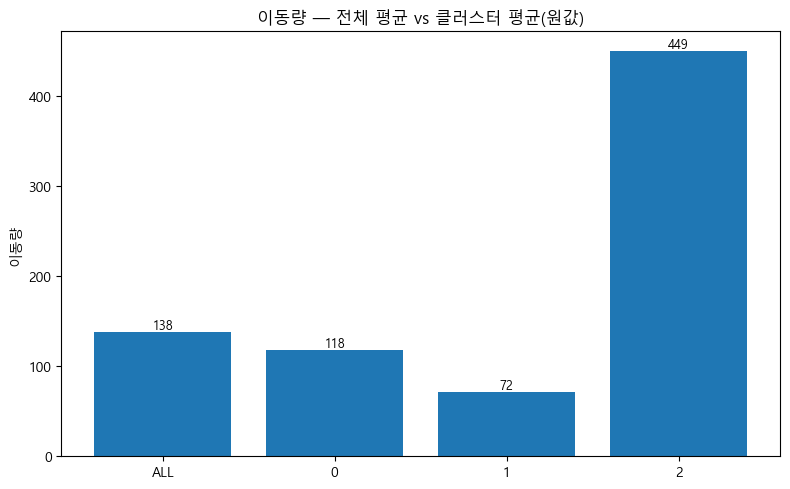

In [87]:
metric = "이동량"

# 전체 평균(ALL) 스칼라 추출
overall = all_means.squeeze()[metric]   

# 클러스터별 평균 Series
cm = cluster_means[metric]             

# 간단한 요약(개수)
above = (cm > overall).sum()
below = (cm < overall).sum()
equal = (cm == overall).sum()

# 막대그래프 
labels = ["ALL"] + [str(c) for c in cm.index]
values = [overall] + cm.tolist()

x = np.arange(len(labels))
plt.figure(figsize=(8,5))
plt.bar(x, values)
plt.xticks(x, labels)
plt.ylabel(metric)
plt.title(f"{metric} — 전체 평균 vs 클러스터 평균(원값)")

# 값 라벨 표시
for xi, v in zip(x, values):
    plt.text(xi, v, f"{v:,.0f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

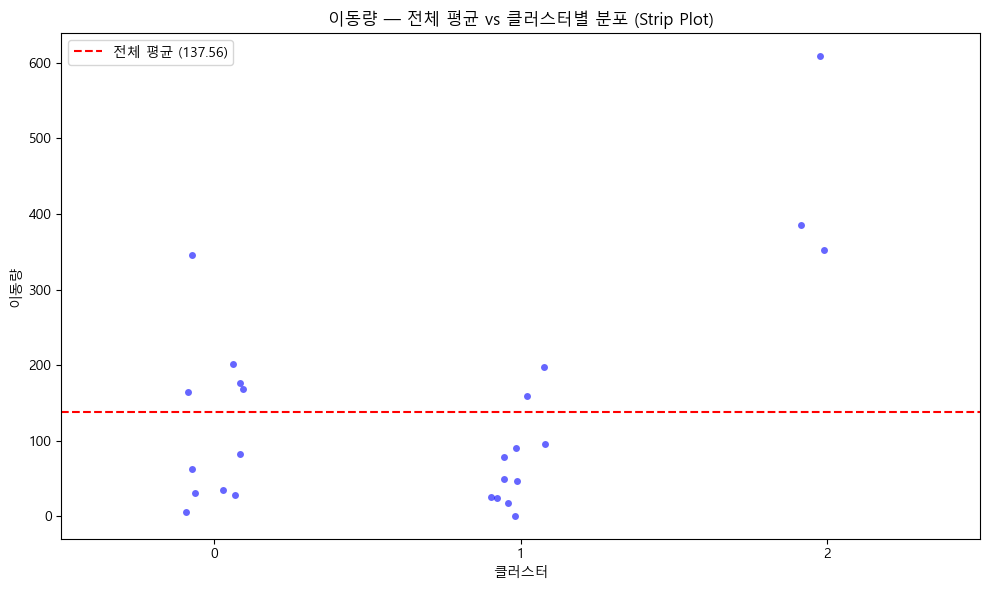

In [89]:
plt.figure(figsize=(10, 6))

sns.stripplot(data=group, x="cluster", y="이동량", jitter=True, color='blue', alpha=0.6)
plt.axhline(y=overall, color='r', linestyle='--', label=f"전체 평균 ({overall:.2f})")
plt.title(f"{metric} — 전체 평균 vs 클러스터별 분포 (Strip Plot)")
plt.xlabel("클러스터")
plt.ylabel(f"{metric}")
plt.legend()

plt.tight_layout()
plt.show()

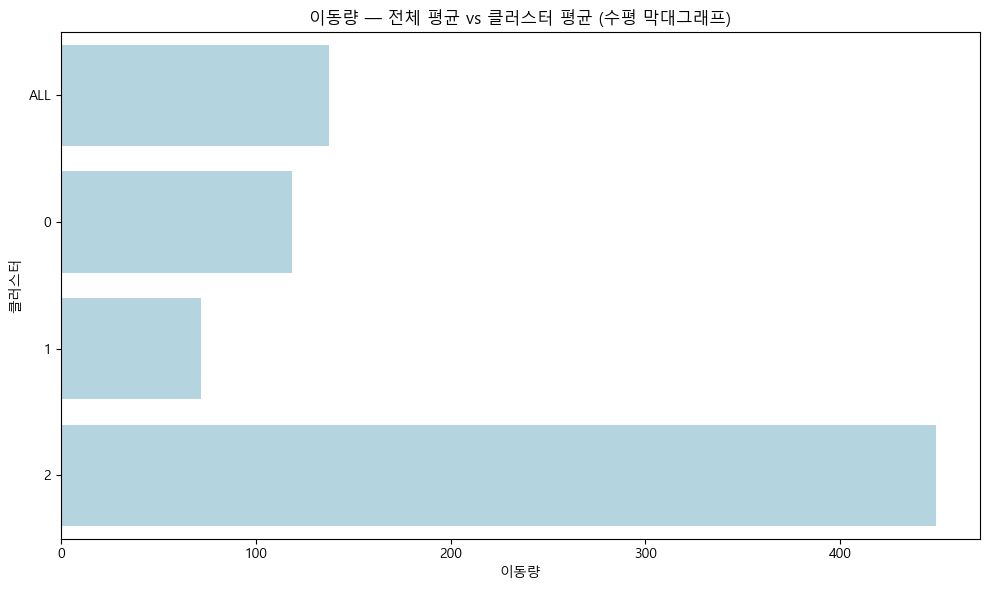

In [91]:
plt.figure(figsize=(10, 6))

sns.barplot(x=[overall] + cm.tolist(), y=["ALL"] + [str(c) for c in cm.index], color="lightblue")
plt.title(f"{metric} — 전체 평균 vs 클러스터 평균 (수평 막대그래프)")
plt.xlabel(f"{metric}")
plt.ylabel("클러스터")

plt.tight_layout()
plt.show()

## 최대최소_편차

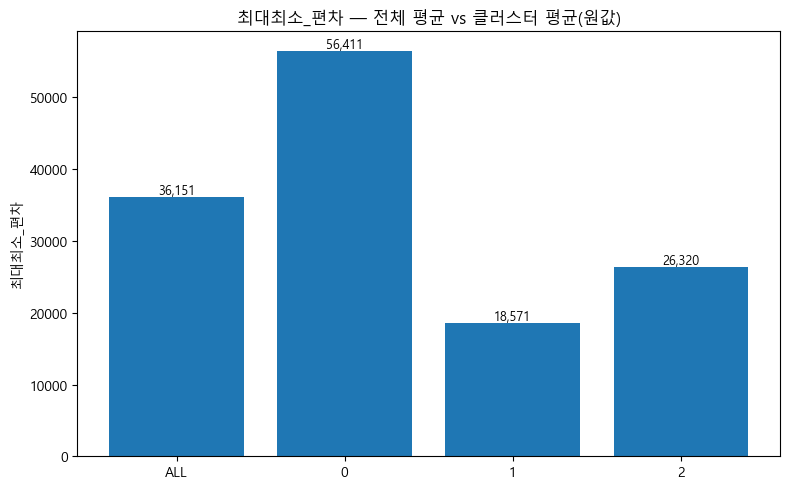

In [94]:
metric = "최대최소_편차"

# 전체 평균(ALL) 스칼라 추출
overall = all_means.squeeze()[metric]   

# 클러스터별 평균 Series
cm = cluster_means[metric]             

# 간단한 요약(개수)
above = (cm > overall).sum()
below = (cm < overall).sum()
equal = (cm == overall).sum()

# 막대그래프 
labels = ["ALL"] + [str(c) for c in cm.index]
values = [overall] + cm.tolist()

x = np.arange(len(labels))
plt.figure(figsize=(8,5))
plt.bar(x, values)
plt.xticks(x, labels)
plt.ylabel(metric)
plt.title(f"{metric} — 전체 평균 vs 클러스터 평균(원값)")

# 값 라벨 표시
for xi, v in zip(x, values):
    plt.text(xi, v, f"{v:,.0f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_20460\3095665762.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=group, x="cluster", y="최대최소_편차", palette="Set1")


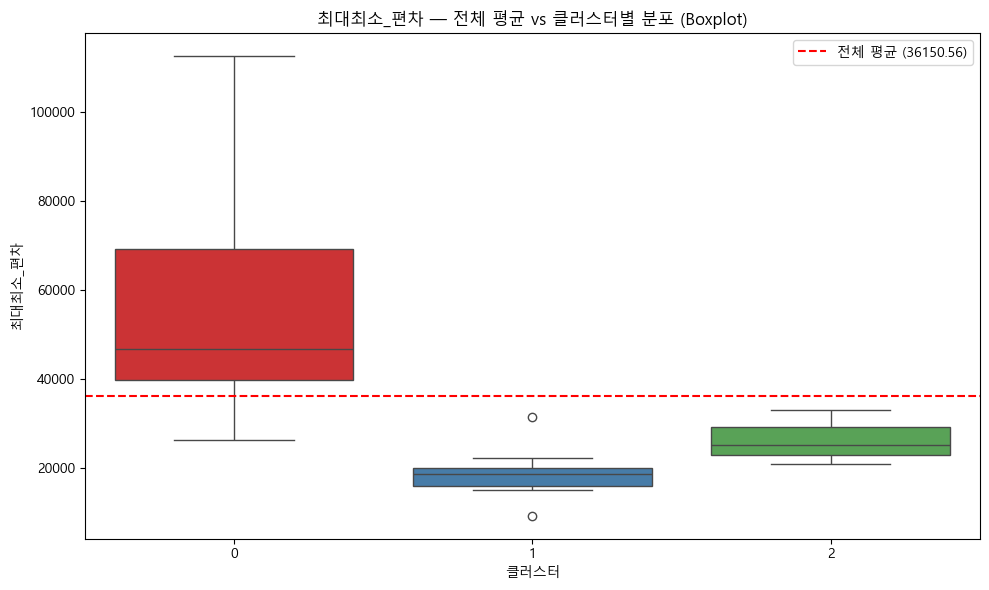

In [96]:
plt.figure(figsize=(10, 6))

sns.boxplot(data=group, x="cluster", y="최대최소_편차", palette="Set1")
plt.axhline(y=overall, color='r', linestyle='--', label=f"전체 평균 ({overall:.2f})")
plt.title(f"{metric} — 전체 평균 vs 클러스터별 분포 (Boxplot)")
plt.xlabel("클러스터")
plt.ylabel(f"{metric}")
plt.legend()

plt.tight_layout()
plt.show()

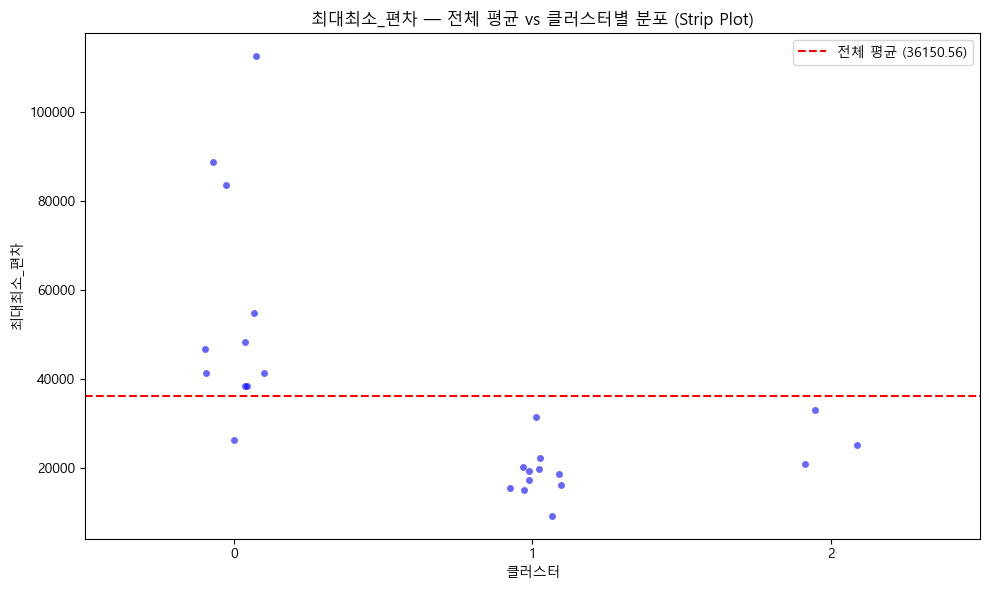

In [98]:
plt.figure(figsize=(10, 6))

sns.stripplot(data=group, x="cluster", y="최대최소_편차", jitter=True, color='blue', alpha=0.6)
plt.axhline(y=overall, color='r', linestyle='--', label=f"전체 평균 ({overall:.2f})")
plt.title(f"{metric} — 전체 평균 vs 클러스터별 분포 (Strip Plot)")
plt.xlabel("클러스터")
plt.ylabel(f"{metric}")
plt.legend()

plt.tight_layout()
plt.show()

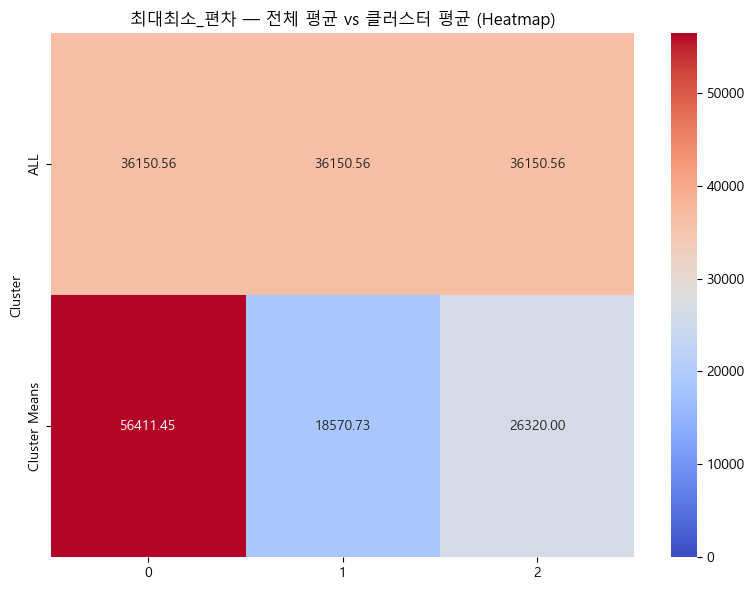

In [100]:
data = pd.DataFrame({
    "ALL": [overall] * len(cm),
    "Cluster Means": cm.tolist()
}, index=[str(c) for c in cm.index])

plt.figure(figsize=(8, 6))
sns.heatmap(data.T, annot=True, cmap="coolwarm", vmin=0, vmax=max(cm.max(), overall), fmt=".2f")
plt.title(f"{metric} — 전체 평균 vs 클러스터 평균 (Heatmap)")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

- 0번 클러스터
  - 클러스터 중 회전율이 가장 높고, 시간대 최대-최소 편차가 크게 벌어지는 그룹
  - 피크 시간대에 수요가 급격히 치솟고 변동성이 높은 지역구들
 
- 1번 클러스터
  - 특정 지표가 두드러지지 않는 안정적인 그룹
  - 전반적으로 과열되지도 않는 기본적인 지역구들
 
- 2번 클러스터
  - 대부분의 지표가 월등히 높아 수요 불균형이 뚜렷하게 나타나는 그룹
  - 따릉이 불균형이 있어 지속적인 재배치가 필요한 지역구들